In [10]:
import numpy as np
import datetime as dt
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import Longitude
import pint as pt
from pint import UnitRegistry
import scipy.optimize
import emcee
import ephem
import math

In [2]:
a = Longitude('-20d')+Longitude('-355d')
print(a)
ureg = UnitRegistry()
ureg.Quantity(10.0,ureg.degC)
ureg.Quantity(10.0,ureg.mbar)

345d00m00s


<Quantity(10.0, 'millibar')>

In [35]:
def compute_Zo(latA, lonA, GHA, DEC):
    # compute LHA from GHA and lonA
    LHA = GHA + lonA
    Zo_rad = np.arcsin(np.sin(DEC.radian)*np.sin(latA.radian) + np.cos(latA.radian)*np.cos(DEC.radian)*np.cos(LHA.radian))
    return Angle(Zo_rad, unit=u.radian)


def dip_correction(h):
    dip_corr = Angle(-0.0293*np.sqrt(h.to_base_units().magnitude), unit=u.deg)
    return dip_corr

def index_correction(IE):
    return Angle('-{.3f}d'.format(IE*60.0))

def atmo_correction(Ha = Angle('15d'), P = ureg.Quantity(1010.0,ureg.mbar), T = ureg.Quantity(10.0,ureg.degC)):

    Pmb = P.to(ureg.mbar)
    TdegC = T.to(ureg.degC)

    f = 0.28*Pmb.magnitude/(TdegC.magnitude + 273)
    Ro = -0.0167/np.tan(np.pi/180.0*(Ha.deg + 7.31/(Ha.deg + 4.4)))
    return Angle(Ro*f,unit=u.deg)

def est_longitude(body, date, time, Hs, IE, h, GHA, DEC, latA, lonA):
    # use a root-finding algorithm to compute the longitude based on an
    # assumed latitude. here, the estimated longitude is to start the root-finding algorithm
    print(repr(dip_correction(h)))
    est_true_H = (Hs.deg + dip_correction(h).deg + index_correction(IE).deg + atmo_correction(Hs).deg + semidiameter_correction(body, date, time))
    #print('Finding Zo for true sextant angle of ' + '{:.3f}'.format(est_true_H) + ' degrees...')
    start_H = compute_Zo(latA, lonA, GHA, DEC).deg
    #print('Starting from value ' + '{:.3f}'.format(start_H) + ' degrees...')
    fz = lambda x: compute_Zo(latA, Angle(x,unit=u.deg), GHA, DEC).deg - (Hs.deg + dip_correction(h).deg + index_correction().deg + atmo_correction(Hs).deg)
    sp_out = scipy.optimize.brentq(fz, lonA.deg-5, lonA.deg+5,maxiter=100)

    return Angle(sp_out, unit=u.deg)

#print(compute_Zo(Angle('17d04m'),Angle('-25d48m'),Angle('93d42.2m'),Angle('-0d25.1m')).to_string(unit=u.degree, sep=('deg', 'm', 's')))
#print(compute_Zo(Angle('17d04m'),Angle('-25d49m'),Angle('356.34d'),Angle('-16d44.4m')).to_string(unit=u.degree, sep=('deg', 'm', 's')))

#print(dip_correction(10*ureg.feet))

#print(atmo_correction(Angle('13d')))

#print(est_longitude(Angle('17d4m'), Angle('-25d48m'), Angle('93d42.2m'), Angle('-0d25.1m'), Angle('21d9m5s'), 10*ureg.feet))
#print(est_longitude(Angle('17d4m'), Angle('-25d49m'), Angle('356.34d'), Angle('-16d44.4m'), Angle('45d32.5m'), 10*ureg.feet))

5


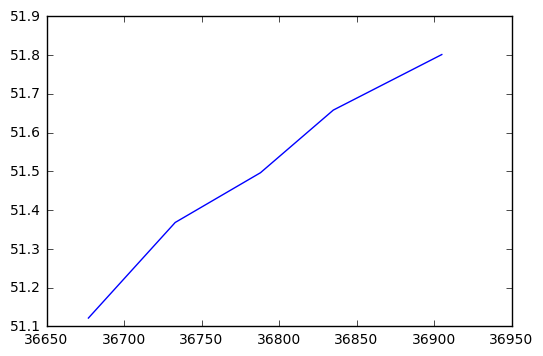

In [7]:
#plot run of sun sights

import matplotlib
import matplotlib.pyplot as plt

sun_sights = [
    [10*3600+11*60+17.0, Angle('51d07.3m')],
    [10*3600+12*60+13, Angle('51d22.1m')],
    [10*3600.0+13*60+8, Angle('51d29.8m')],
    [10*3600.0+13*60+55.0, Angle('51d39.5m')],
    [10*3600+15*60+5.0, Angle('51d48.1m')]
]
print(len(sun_sights))
# process list into 2d array

sun_sights_processed = np.zeros((len(sun_sights),2))
for i in range(len(sun_sights)):
    sun_sights_processed[i,0] = sun_sights[i][0]
    sun_sights_processed[i,1] = sun_sights[i][1].deg
    
plt.plot(sun_sights_processed[:,0],sun_sights_processed[:,1])
plt.show()

In [37]:
# 'database' of sightings for reduction into a single lat/long pair + course speed/heading

db_sights = """\
SunLL,2015/02/21,12:00:00,51d07.3m,0.0,2.0m,2.44,5.5,270d,17d4m,-27d7m
SunLL,2015/02/22,12:00:00,51d22.1m,0.0,2.0m,2.44,5.5,270d,17d4m,-27d7m
SunLL,2015/02/22,12:13:08,51d29.8m,0.0,2.0m,2.44,5.5,270d,17d4m,-27d7m
SunLL,2015/02/22,12:13:55,51d39.5m,0.0,2.0m,2.44,5.5,270d,17d4m,-27d7m
SunLL,2015/02/22,12:15:05,51d39.5m,0.0,2.0m,2.44,5.5,270d,17d4m,-27d7m
"""

db_sights_split = db_sights.split('\n')
# remove last element
del db_sights_split[-1]

def nadeg(deg):
    #changes ephem.angel (rad) to the format for the Angle class.
    theminus = ""
    if deg < 0:
    	theminus = "-"
    g = int(math.degrees(deg))
    m = (math.degrees(deg)-g)*60
    gm = "%s%sd%04.1fm" %(theminus,abs(g),abs(m))
    return gm

def compute_GHA_DEC(body, date, time):
    if body == 'SunLL' or 'SunUL':
        s = ephem.Sun()
        obs = ephem.Observer()
        date_string = date + ' ' + time
        obs.date = date_string
        
        s.compute(date_string,epoch=date_string)

        deg = ephem.degrees(obs.sidereal_time()-s.g_ra).norm
        ghas = nadeg(deg)
        deg = s.g_dec
        decs = nadeg(deg)

    return ghas, decs

def semidiameter_correction(body, date, time):
    if body == 'SunLL' or 'SunUL':
        s = ephem.Sun()
        obs = ephem.Observer()
        date_string = date + ' ' + time
        obs.date = date_string
        
        s.compute(date_string,epoch=date_string)
        # compute SD of sun
        sds = s.radius/ephem.pi*180.0 # degrees of arc
        if body == 'SunLL':
            return Angle('{:.3f}d'.format(sds))
        else:
            return Angle('{:.3f}d'.format(sds))
        
    return Angle('0d')
        

# preprocess the array of sights into corrected sightings based on ephemeris from pyephem
for i in range(len(db_sights_split)):
    body, date, time, Hs, WE, IE, height, DRv, DRheading, latA, lonA = db_sights_split[i].split(',') # split into line elements
    # coerce values from strings to objects
    # ignores watch error (WE)
    WE = float(WE)
    IE = float(IE)
    height = float(height)*ureg.meter
    DRv = float(DRv)
    DRheading = Angle(DRheading,unit=u.deg) # FIX THIS TO APPROPRIATE COORDINATES
    latA = Angle(latA,unit=u.deg)
    lonA = Angle(lonA,unit=u.deg)
    
    # process based on body
    if body == 'SunLL':
        GHAc, DECc = compute_GHA_DEC(body, date, time)
        sd = semidiameter_correction(body, date, time)
        print('date: {}'.format(date + ' ' + time))
        print('GHA: {}, DEC: {}'.format(GHAc, DECc))
        print('semidiameter: {}'.format(sd))
    
    # estimate the location
    # function def is: est_longitude(body, date, time, Hs, IE, h, GHA, DEC, latA, lonA):
    est_long = est_longitude(body, date, time, Hs, IE, float(height)*ureg.meter, GHAc, DECc, latA, lonA)
    

date: 2015/02/21 12:00:00
GHA: 356d35.7m, DEC: -10d34.3m
semidiameter: 0.27 deg
<Angle -0.045768063100812995 deg>


AttributeError: 'str' object has no attribute 'deg'